In [1]:
import gym
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from functools import partial
%matplotlib inline
plt.style.use('ggplot')

In [2]:
env = gym.make('Blackjack-v1')

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [3]:
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

In [4]:
def generate_episode(policy, env):
    
    # we initialize the list for storing states, actions, and rewards
    states, actions, rewards = [], [], []
    
    # Initialize the gym environment
    observation = env.reset()
    
    while True:
        
        # append the states to the states list
        states.append(observation)
        
        # now, we select an action using our sample_policy function and append the action to actions list
         
        action = sample_policy(observation)
        actions.append(action)
        
        # We perform the action in the environment according to our sample_policy, move to the next state 
        # and receive reward
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        
        # Break if the state is a terminal state
        if done:
             break
                
    return states, actions, rewards

In [5]:
def first_visit_mc_prediction(policy, env, n_episodes):
    
    # First, we initialize the empty value table as a dictionary for storing the values of each state
    value_table = defaultdict(float)
    N = defaultdict(int)

    
    for _ in range(n_episodes):
        
        # Next, we generate the epsiode and store the states and rewards
        states, _, rewards = generate_episode(policy, env)
        returns = 0
        
        # Then for each step, we store the rewards to a variable R and states to S, and we calculate
        # returns as a sum of rewards
        
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]
            
            returns += R
            
            # Now to perform first visit MC, we check if the episode is visited for the first time, if yes,
            # we simply take the average of returns and assign the value of the state as an average of returns
            
            if S not in states[:t]:
                N[S] += 1
                value_table[S] += (returns - value_table[S]) / N[S]
    
    return value_table

In [6]:
value = first_visit_mc_prediction(sample_policy, env, n_episodes=500000)

In [7]:
for i in range(10):
      print(value.popitem())

((12, 2, True), -0.16379310344827572)
((4, 7, False), -0.3973214285714283)
((18, 7, True), -0.4078212290502791)
((15, 7, True), -0.34482758620689685)
((12, 9, True), -0.2625)
((12, 3, True), -0.24390243902439027)
((13, 7, True), -0.2177033492822967)
((12, 8, True), -0.26267281105990786)
((15, 1, True), -0.5328185328185323)
((17, 1, True), -0.5385802469135813)


In [8]:
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))

    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V[player, dealer, ace]
    
    X, Y = np.meshgrid(player_sum, dealer_show)
 
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
 
    for ax in ax1, ax2:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer showing')
        ax.set_zlabel('state-value')
        

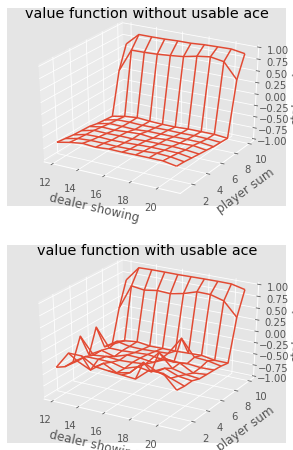

In [9]:
fig, axes = pyplot.subplots(nrows=2, figsize=(5, 8),
subplot_kw={'projection': '3d'})
axes[0].set_title('value function without usable ace')
axes[1].set_title('value function with usable ace')
plot_blackjack(value, axes[0], axes[1])